In [1]:
import os
import csv
import pandas as pd
import random
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

DATA_DIR = './'
OUTPUT_DIR = './'

class Config:
    device='cpu'
    epochs=40
    seed=17
    train_bs=8
    valid_bs=8
    embedding_dim=20
    lr=1e-2
    num_workers=None       
    verbose_step=100
    
def torch_seed_everything(seed_value=777):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

config=Config()
torch_seed_everything(config.seed)

# load full data

In [27]:
df = pd.read_csv(os.path.join(DATA_DIR, 'u.data'), sep='\t', header=None)
df.columns = ['user_id', 'item_id', 'rating', 'timestamp']
#df = df.sort_values('timestamp').reset_index(drop=True)
n_user = df.user_id.nunique()
n_item = df.item_id.nunique()
df

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


Data clustering into 3 blocks


In [9]:
csvfile = open('u.data', 'r').readlines()
filename = 1
for i in range(len(csvfile)):
     if i % 33334 == 0:
         open(str(filename) + '.data', 'w+').writelines(csvfile[i:i+33333])
         filename += 1

In [29]:
df1 = pd.read_csv(os.path.join(DATA_DIR, '1.data'), sep='\t', header=None)
df1.columns = ['user_id', 'item_id', 'rating', 'timestamp']
n_user = df.user_id.nunique()
n_item = df.item_id.nunique()
df1

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
33328,194,159,3,879552401
33329,124,168,5,890287645
33330,364,319,3,875931309
33331,533,96,4,879438767


In [17]:
df2 = pd.read_csv(os.path.join(DATA_DIR, '2.data'), sep='\t', header=None)
df2.columns = ['user_id', 'item_id', 'rating', 'timestamp']
#df = df.sort_values('timestamp').reset_index(drop=True)
n_user2 = df2.user_id.nunique()
n_item2 = df2.item_id.nunique()
df2

,user_id,item_id,rating,timestamp
0,434,148,3,886724797
1,458,408,5,886396637
2,109,156,5,880573084
3,76,547,2,882607017
4,7,595,2,891353801
...,...,...,...,...
33328,698,1021,1,886367615
33329,871,335,3,888192475
33330,655,204,3,887477192
33331,674,742,5,887762714


In [18]:
df3 = pd.read_csv(os.path.join(DATA_DIR, '3.data'), sep='\t', header=None)
df3.columns = ['user_id', 'item_id', 'rating', 'timestamp']
#df = df.sort_values('timestamp').reset_index(drop=True)
n_user3 = df3.user_id.nunique()
n_item3 = df3.item_id.nunique()
df3

,user_id,item_id,rating,timestamp
0,788,227,3,880867890
1,606,585,4,880927358
2,806,1074,3,882390515
3,334,129,4,891544735
4,828,270,5,891034148
...,...,...,...,...
33327,880,476,3,880175444
33328,716,204,5,879795543
33329,276,1090,1,874795795
33330,13,225,2,882399156


In [20]:
print('user_num1', n_user1)
print('item_num1', n_item1)
print('user_num2', n_user2)
print('item_num2', n_item2)
print('user_num3', n_user3)
print('item_num3', n_item3)

user_num1 943
item_num1 1682
user_num2 928
item_num2 1509
user_num3 941
item_num3 1504


# split data for cluster 1

In [33]:
train_df, valid_df = train_test_split(df1, test_size=0.2, random_state=config.seed)
# assert train_df.user_id.nunique() == valid_df.user_id.nunique()
print(train_df.shape, valid_df.shape)
#print(valid_df.user_id.nunique())

(26666, 4) (6667, 4)


In [40]:
class MF:
    """
    Matrix factorization class. 
    """
    def __init__(self,lmbda = 0.01, learning_rate=0.001,max_iteration=10000,rank=10,verbose=True,gap=None):
        """
        params
        ------
        lmbda: float. Regularizer parameter.
        
        learning_rate: float. Step size or learning rate of SGD
        
        max_iteration: int. 
        
        rank: int. Embedding dimension of the U,V matrix where A = U.V
        
        verbose: bool. Whether to print iteration log or not.
        
        gap: bool. 
            Gap between each iteration log when verbose is true. Default value is 10th factor of max_iteration.
        """
        self.lmbda = lmbda
        self.lr = learning_rate
        self.max_iteration = max_iteration
        self.rank = rank
        self.verb = verbose
        self.gap = gap
        self.U = None
        self.V = None
        self.gap = (max_iteration / 10) if gap is None else gap
        
    def mse(self,truth, pred):
        """Returns the mse of nonzero errors"""
        pred = pred[truth.nonzero()].flatten()
        truth = truth[truth.nonzero()].flatten()
        return mean_squared_error(truth, pred)

    def graph(self,testset=False):
        """
        Training and test graph with other meta data.
        """
        fig, ax = plt.subplots(facecolor='white',figsize=(10,5))
        train = [w[0] for w in self.history]
        test = [w[1] for w in self.history]
        x = list(range(0,self.max_iteration+2,int(self.gap)))
        ax.plot(x,train,color='red',label='Train MSE')
        if testset==True:
            ax.plot(x,test,color='green',label='Test MSE')
        ax.legend()
        ax.grid(True)
        ax.set_xlabel("Iteration")
        ax.set_ylabel("MSE")
        caption = f'lmbda: {lmb} lr: {self.lr} iteration: {self.max_iteration}'
        plt.title(caption)
        plt.show()

    def predict(self,query_embedding,type='neighbour',name='Aladdin',measure='cosine'):
        """
        params
        ------
        query_embedding: 1D array. 
            Query's embeddding vector. For example if we want to find similar movies like Aladdin,
            query_embedding will be Aladdin's vector from V. 
        V: array-like. 2d. Item embedding.
        type: {similar, suggest}. 
            Not in use now. for future functionality.
        name: str. Movie name.
        measure: {dot,cosine}
            similarity measure for query and V. 

        returns
        -------
        sim_vector: similarity vector between query_embedding and V.
        """
        
        u = query_embedding
        V = self.V
        if measure == 'cosine':
            V = V / np.linalg.norm(V, axis=1, keepdims=True)
            u = u / np.linalg.norm(u)
        sim_vector = u.dot(V.T)
        return sim_vector

    
    def SGD(self,A,rated_rows,rated_cols,A_test=None):
        """
        Stochastic Gradient Descent. 
        
        params
        ------
        A: 2D array. shape(n_user,n_item)
            Training rating matrix. 
        
        rated_rows: 1D array.
            Observed indices rows from A. Meaning i where A_{i,j} > 0.
        
        rated_cols: 1D array.
            Observed indices' column from A. Meaning j where A_{i,j} > 0.
            
        A_test: Test A.
            *optional.*
            
        returns
        -------
        none
        """
        print("Master Yoda has started teaching...")
        self.history= []
        for itr in range(self.max_iteration):
            # choosing an observed user,item combination
            u = np.random.choice(rated_rows)
            i = np.random.choice(rated_cols)
            #forward pass
            error = A[u,i] - np.dot(self.U[u], self.V[i])  # check this line alone
    #         cost = error**2 + lmbda * (np.linalg.norm(self.U[u])**2 + np.linalg.norm(self.V[i])**2)        
            # backward pass
            tmp = self.U[u]
            self.U[u] = self.U[u] + self.lr * (error * self.V[i] - self.lmbda * self.U[u])
            self.V[i] = self.V[i] + self.lr * (error * tmp - self.lmbda * self.V[i])
            
            if (itr % self.gap) == 0 or itr == self.max_iteration - 1:
                A_hat = np.dot(self.U,self.V.T)
                train_mse = self.mse(A,A_hat)
                test_mse = -1
                if isinstance(A_test,np.ndarray):
                    test_mse = self.mse(A_test,A_hat)
                self.history.append((train_mse,test_mse))
                if self.verb==True:
                    print("iteration %d, TrainMSE: %.2f TestMSE: %.2f"%
                          (itr,train_mse,test_mse))
    
    def fit(self,A,A_test=None):
        """
        Fit the U,V to A.
        """
        rated_rows,rated_cols = A.nonzero()
        n_user = A.shape[0]
        n_item = A.shape[1]
        if self.U is None:
            self.U = np.random.rand(n_user,self.rank)
            self.V = np.random.rand(n_item,self.rank)
        # used in verbose mode
        self.SGD(A,rated_rows,rated_cols,A_test)

In [45]:
def split(data):
    """
    Splits 100k data between train and test set, and builts corresponding rating matrix, A for each set
    """
    # n_user = data.userid.nunique()
    # n_item = data.itemid.nunique()
    train,test = train_test_split(data,test_size=0.3)
    def fun1(x):
        A_train[x[0],x[1]] = x[2]
        return x
    def fun2(x):
        A_test[x[0],x[1]] = x[2]
        return x
    A_train = np.zeros((n_user,n_item))
    A_test = np.zeros((n_user,n_item))
    train.apply(fun1, axis=1)
    test.apply(fun2,axis=1)
    return A_train, A_test

In [46]:
A_train,A_test = split(df1)

Master Yoda has started teaching...
iteration 0, TrainMSE: 19.24 TestMSE: 19.49
iteration 3600, TrainMSE: 12.67 TestMSE: 12.89
iteration 7200, TrainMSE: 8.75 TestMSE: 8.92
iteration 10800, TrainMSE: 6.38 TestMSE: 6.53
iteration 14400, TrainMSE: 4.92 TestMSE: 5.05
iteration 18000, TrainMSE: 4.06 TestMSE: 4.15
iteration 21600, TrainMSE: 3.55 TestMSE: 3.63
iteration 25200, TrainMSE: 3.28 TestMSE: 3.34
iteration 28800, TrainMSE: 3.16 TestMSE: 3.21
iteration 32400, TrainMSE: 3.14 TestMSE: 3.18
iteration 35999, TrainMSE: 3.21 TestMSE: 3.23


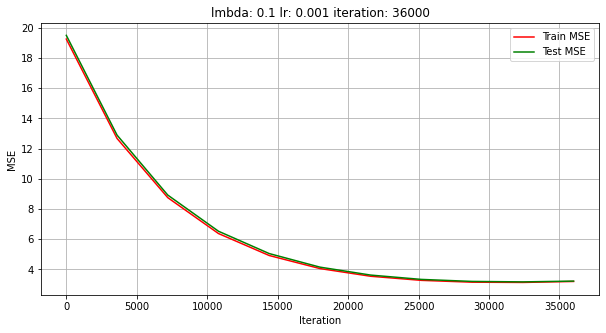

In [51]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from IPython import display
import matplotlib.pyplot as plt

lmb = 0.1
lr = 0.001
mx_itr = 36000
gap = mx_itr / 10
view = True

model = MF(lmb,learning_rate=lr,max_iteration=mx_itr,rank=30,verbose=True)
model.fit(A_train,A_test)
model.graph(testset=True)

In [52]:
def get_movie_suggestion(model,name='Aladdin'):
    # might return multiple movies
    movieids =  item[item['movie_title'].str.contains(name)].index.values
    if len(movieids) == 0:
        print('No movie found by that name. Remember, searching is case-sensitive')
        return
    print('Found ',len(movieids),'searching by: ',item.loc[movieids[0],'movie_title'])
    query = model.V[movieids[0]] # a single movie embedding
    sim_vector = model.predict(query)
    item['similarity'] = sim_vector
    top5 = item.sort_values(['similarity'],axis=0,inplace=False,ascending=False)[
        ['itemid','movie_title','genre','similarity','IMDb_URL']
    ].head()
#     top5 = top5.append(item.loc[movieids[0],['itemid','movie_title','genre','similarity']])
    display.display(top5)

In [57]:
# data
itemcol = [w.strip().replace(" ","_") for w in "itemid | movie_title | release_date | video release date |IMDb URL | unknown | Action | Adventure | Animation |Children's | Comedy | Crime | Documentary | Drama | Fantasy |Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |Thriller | War | Western |".split('|')]
itemcol.remove('')
item = pd.read_csv("u.item",delimiter='|',
                   names=itemcol,encoding='latin_1')

item['itemid'] = item['itemid'].apply(lambda x: x - 1)
# Genre aggregate
def genre(series):
    genres = series.index[6:-2]
    
    text = []
    for i in genres:
        if series[i] == 1:
            text.append(i)
    return ", ".join(text)
item['genre'] = item.apply(genre,axis=1)
get_movie_suggestion(model,name='GoldenEye')

Found  1 searching by:  GoldenEye (1995)


,itemid,movie_title,genre,similarity,IMDb_URL
1,1,GoldenEye (1995),"Action, Adventure, Thriller",1.000000,http://us.imdb.com/M/title-exact?GoldenEye%20(...
1268,1268,Love in the Afternoon (1957),"Comedy, Romance",0.800428,http://us.imdb.com/M/title-exact?Love%20in%20t...
1337,1337,Two Deaths (1995),Drama,0.798305,http://us.imdb.com/Title?Two+Deaths+(1995)
502,502,"Candidate, The (1972)",Drama,0.795550,"http://us.imdb.com/M/title-exact?Candidate,%20..."
1105,1105,"Newton Boys, The (1998)","Crime, Drama",0.793771,"http://us.imdb.com/Title?Newton+Boys,+The+(1998)"


# Dataset

In [34]:
class MovieLensDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        user_id, item_id, rating, _ = self.df.iloc[idx]
        # index starts with 0
        sample = {"user": user_id - 1, "item": item_id - 1, "rating": rating}
        return sample

# model

In [35]:
class MatrixFactorizationPyTorch(nn.Module):
    def __init__(self, n_user, n_item, k=20):
        """
        n_user: user num
        n_item: item num
        k: embedding dim
        """
        super().__init__()
        self.user_factors = nn.Embedding(n_user, k, sparse=True)
        self.item_factors = nn.Embedding(n_item, k, sparse=True)

    def forward(self, user, item):
        #print(user, item)
        u_emb = self.user_factors(user)
        i_emb = self.item_factors(item)
        # print(u_emb.shape, i_emb.shape)
        # print((u_emb * i_emb).shape)
        # print((u_emb * i_emb).sum(axis=1).shape)
        return (u_emb * i_emb).sum(axis=1)

In [36]:
train_loader = DataLoader(MovieLensDataset(train_df), batch_size=2, shuffle=True,)
next(iter(train_loader))

{'item': tensor([944, 257]),
 'rating': tensor([4, 4]),
 'user': tensor([307,  23])}

In [37]:
data = next(iter(train_loader))
user, item = data['user'], data['item']
model = MatrixFactorizationPyTorch(n_user, n_item, k=config.embedding_dim)
model(user, item)

tensor([1.3618, 1.5302], grad_fn=<SumBackward1>)

# train

In [38]:
def train_one_epoch(epoch, model, loss_fn, optimizer,
                    train_loader, device, scheduler=None):
    model.train()
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    data_cnt = 0
    total_loss = 0.0

    # 学習データをシャッフルしてループ
    for step, data in pbar:
        user = data['user']
        item = data['item']
        rating = data['rating']
        data_cnt += user.shape[0]

        # 勾配リセット
        optimizer.zero_grad()

        #順伝搬、逆伝搬
        outputs = model(user, item)
        #print('outupts', outputs)
        #print(rating)
        loss = loss_fn(outputs,  rating.float())
        #print('loss', loss)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        #print(total_loss)
        if ((step + 1) % config.verbose_step == 0) or ((step + 1) == len(train_loader)):
            description = f'train epoch {epoch} loss: {total_loss / data_cnt:.4f}'
            pbar.set_description(description)

    total_loss = total_loss / len(train_loader)
    print('train loss = {:.4f}'.format(total_loss))

def valid_one_epoch(epoch, model, loss_fn, val_loader, device):

    model.eval()
    total_loss = 0.0
    data_cnt = 0
    #preds = []
    pbar = tqdm(enumerate(val_loader), total=len(val_loader))

    for step, data in pbar:
        user = data['user']
        item = data['item']
        rating = data['rating']
        data_cnt += user.shape[0]

        outputs = model(user, item)
        loss = loss_fn(outputs, rating)
        total_loss += loss
        
        # preds.append(outputs.detach().cpu().numpy())

        if ((step + 1) % config.verbose_step == 0) or ((step + 1) == len(val_loader)):
            description = f'val epoch {epoch} loss: {total_loss / data_cnt:.4f}'
            pbar.set_description(description)
        

    valid_loss = total_loss / len(val_loader)
    print('val loss = {:.4f}'.format(valid_loss))
    return valid_loss 

def run_train(train_loader, valid_loader):
    device = torch.device(config.device)
    model = MatrixFactorizationPyTorch(n_user, n_item, k=config.embedding_dim)
    loss_fn = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=config.lr)
    best_loss=1e10
    for epoch in range(config.epochs):
        train_one_epoch(epoch, model, loss_fn, optimizer, train_loader, device)

        with torch.no_grad():
            val_loss = valid_one_epoch(epoch, model, loss_fn, valid_loader, device)
        
        if best_loss > val_loss:
            best_loss = val_loss
            best_rmse = torch.sqrt(best_loss)
            best_epoch = epoch
            # TODO: save model,  figure
            best_path =  os.path.join(OUTPUT_DIR,f'best_model.bin')
            torch.save({'model':model.state_dict(),},
                           best_path)
    print(f'----- result ------')
    print(f'Best epoch: {epoch}')
    print(f'Best loss: {best_loss}, RMSE: {best_rmse}')

In [39]:
train_loader = DataLoader(MovieLensDataset(train_df), batch_size=config.train_bs, shuffle=True,)
valid_loader = DataLoader(MovieLensDataset(valid_df), batch_size=config.valid_bs, shuffle=False,)
run_train(train_loader, valid_loader)

val epoch 0 loss: 3.2194:   8%|▊         | 66/834 [00:00<00:01, 651.85it/s]

train loss = 28.4497


  1%|▏         | 47/3334 [00:00<00:07, 463.73it/s]

val loss = 25.2508


val epoch 1 loss: 2.8111:   8%|▊         | 66/834 [00:00<00:01, 651.43it/s]

train loss = 19.6061


  1%|▏         | 50/3334 [00:00<00:06, 499.69it/s]

val loss = 21.9644


val epoch 2 loss: 2.5443:   8%|▊         | 63/834 [00:00<00:01, 625.87it/s]

train loss = 15.5193


  1%|▏         | 49/3334 [00:00<00:06, 478.53it/s]

val loss = 19.8336


val epoch 3 loss: 2.2871:   8%|▊         | 64/834 [00:00<00:01, 637.27it/s]

train loss = 12.6547


  1%|▏         | 50/3334 [00:00<00:06, 495.87it/s]

val loss = 17.8111


val epoch 4 loss: 2.0096:   8%|▊         | 65/834 [00:00<00:01, 645.41it/s]

train loss = 10.1551


  2%|▏         | 52/3334 [00:00<00:06, 511.59it/s]

val loss = 15.6955


val epoch 5 loss: 1.7437:   7%|▋         | 57/834 [00:00<00:01, 562.61it/s]

train loss = 7.9859


  2%|▏         | 51/3334 [00:00<00:06, 508.05it/s]

val loss = 13.7149


val epoch 6 loss: 1.5186:   8%|▊         | 70/834 [00:00<00:01, 695.93it/s]

train loss = 6.2895


  2%|▏         | 51/3334 [00:00<00:06, 503.92it/s]

val loss = 12.0842


val epoch 7 loss: 1.3401:   8%|▊         | 70/834 [00:00<00:01, 696.24it/s]

train loss = 5.0550


  2%|▏         | 53/3334 [00:00<00:06, 523.21it/s]

val loss = 10.8158


val epoch 8 loss: 1.1996:   7%|▋         | 62/834 [00:00<00:01, 605.84it/s]

train loss = 4.1614


  1%|▏         | 48/3334 [00:00<00:06, 474.28it/s]

val loss = 9.8304


val epoch 9 loss: 1.0894:   8%|▊         | 65/834 [00:00<00:01, 649.73it/s]

train loss = 3.5055


  2%|▏         | 51/3334 [00:00<00:06, 509.02it/s]

val loss = 9.0534


val epoch 10 loss: 1.0019:   8%|▊         | 68/834 [00:00<00:01, 673.76it/s]

train loss = 3.0111


  1%|▏         | 48/3334 [00:00<00:06, 477.83it/s]

val loss = 8.4337


val epoch 11 loss: 0.9319:   8%|▊         | 69/834 [00:00<00:01, 688.55it/s]

train loss = 2.6295


  1%|▏         | 44/3334 [00:00<00:07, 436.11it/s]

val loss = 7.9325


val epoch 12 loss: 0.8747:   7%|▋         | 61/834 [00:00<00:01, 601.71it/s]

train loss = 2.3292


  1%|▏         | 43/3334 [00:00<00:07, 422.07it/s]

val loss = 7.5171


val epoch 13 loss: 0.8280:   7%|▋         | 62/834 [00:00<00:01, 613.63it/s]

train loss = 2.0882


  1%|▏         | 50/3334 [00:00<00:06, 490.83it/s]

val loss = 7.1680


val epoch 14 loss: 0.7879:   8%|▊         | 65/834 [00:00<00:01, 645.62it/s]

train loss = 1.8917


  1%|▏         | 49/3334 [00:00<00:06, 485.23it/s]

val loss = 6.8734


val epoch 15 loss: 0.7540:   8%|▊         | 69/834 [00:00<00:01, 682.47it/s]

train loss = 1.7297


  1%|▏         | 50/3334 [00:00<00:06, 490.81it/s]

val loss = 6.6164


val epoch 16 loss: 0.7258:   7%|▋         | 56/834 [00:00<00:01, 555.26it/s]

train loss = 1.5940


  1%|▏         | 46/3334 [00:00<00:07, 452.93it/s]

val loss = 6.3979


val epoch 17 loss: 0.7010:   8%|▊         | 64/834 [00:00<00:01, 638.36it/s]

train loss = 1.4796


  1%|▏         | 48/3334 [00:00<00:06, 475.99it/s]

val loss = 6.2056


val epoch 18 loss: 0.6795:   7%|▋         | 60/834 [00:00<00:01, 591.82it/s]

train loss = 1.3815


  1%|▏         | 43/3334 [00:00<00:07, 421.50it/s]

val loss = 6.0385


val epoch 19 loss: 0.6608:   8%|▊         | 69/834 [00:00<00:01, 666.86it/s]

train loss = 1.2978


  1%|▏         | 49/3334 [00:00<00:06, 484.16it/s]

val loss = 5.8890


val epoch 20 loss: 0.6445:   8%|▊         | 63/834 [00:00<00:01, 622.72it/s]

train loss = 1.2242


  1%|▏         | 43/3334 [00:00<00:07, 427.99it/s]

val loss = 5.7568


val epoch 21 loss: 0.6301:   8%|▊         | 67/834 [00:00<00:01, 663.50it/s]

train loss = 1.1607


  2%|▏         | 51/3334 [00:00<00:06, 507.15it/s]

val loss = 5.6389


val epoch 22 loss: 0.6170:   7%|▋         | 60/834 [00:00<00:01, 597.09it/s]

train loss = 1.1043


  1%|▏         | 49/3334 [00:00<00:06, 488.67it/s]

val loss = 5.5323


val epoch 23 loss: 0.6055:   8%|▊         | 69/834 [00:00<00:01, 685.48it/s]

train loss = 1.0546


  1%|▏         | 48/3334 [00:00<00:06, 475.85it/s]

val loss = 5.4354


val epoch 24 loss: 0.5945:   7%|▋         | 55/834 [00:00<00:01, 547.09it/s]

train loss = 1.0103


  1%|▏         | 46/3334 [00:00<00:07, 458.19it/s]

val loss = 5.3464


val epoch 25 loss: 0.5854:   8%|▊         | 63/834 [00:00<00:01, 627.38it/s]

train loss = 0.9708


  1%|▏         | 47/3334 [00:00<00:07, 462.79it/s]

val loss = 5.2663


val epoch 26 loss: 0.5769:   6%|▋         | 54/834 [00:00<00:01, 535.83it/s]

train loss = 0.9353


  1%|▏         | 47/3334 [00:00<00:07, 466.54it/s]

val loss = 5.1934


val epoch 27 loss: 0.5689:   8%|▊         | 66/834 [00:00<00:01, 651.57it/s]

train loss = 0.9029


  1%|▏         | 44/3334 [00:00<00:07, 431.56it/s]

val loss = 5.1252


val epoch 28 loss: 0.5616:   8%|▊         | 64/834 [00:00<00:01, 631.24it/s]

train loss = 0.8738


  2%|▏         | 52/3334 [00:00<00:06, 514.06it/s]

val loss = 5.0627


val epoch 29 loss: 0.5551:   8%|▊         | 68/834 [00:00<00:01, 671.50it/s]

train loss = 0.8476


  1%|▏         | 50/3334 [00:00<00:06, 491.78it/s]

val loss = 5.0064


val epoch 30 loss: 0.5492:   7%|▋         | 60/834 [00:00<00:01, 599.02it/s]

train loss = 0.8229


  2%|▏         | 52/3334 [00:00<00:06, 513.23it/s]

val loss = 4.9542


val epoch 31 loss: 0.5433:   8%|▊         | 65/834 [00:00<00:01, 649.67it/s]

train loss = 0.8006


  1%|▏         | 48/3334 [00:00<00:06, 476.63it/s]

val loss = 4.9057


val epoch 32 loss: 0.5377:   8%|▊         | 66/834 [00:00<00:01, 652.00it/s]

train loss = 0.7802


  1%|▏         | 46/3334 [00:00<00:07, 454.72it/s]

val loss = 4.8581


val epoch 33 loss: 0.5332:   8%|▊         | 63/834 [00:00<00:01, 622.99it/s]

train loss = 0.7617


  1%|▏         | 46/3334 [00:00<00:07, 455.16it/s]

val loss = 4.8166


val epoch 34 loss: 0.5289:   8%|▊         | 66/834 [00:00<00:01, 649.85it/s]

train loss = 0.7437


  1%|          | 39/3334 [00:00<00:08, 385.41it/s]

val loss = 4.7770


val epoch 35 loss: 0.5242:   8%|▊         | 69/834 [00:00<00:01, 685.45it/s]

train loss = 0.7275


  1%|▏         | 46/3334 [00:00<00:07, 455.87it/s]

val loss = 4.7396


val epoch 36 loss: 0.5205:   6%|▌         | 47/834 [00:00<00:01, 463.60it/s]

train loss = 0.7124


  1%|▏         | 47/3334 [00:00<00:07, 464.06it/s]

val loss = 4.7053


val epoch 37 loss: 0.5167:   7%|▋         | 61/834 [00:00<00:01, 607.89it/s]

train loss = 0.6982


  1%|▏         | 46/3334 [00:00<00:07, 457.06it/s]

val loss = 4.6724


val epoch 38 loss: 0.5134:   8%|▊         | 64/834 [00:00<00:01, 639.47it/s]

train loss = 0.6849


  2%|▏         | 52/3334 [00:00<00:06, 510.92it/s]

val loss = 4.6419


val epoch 39 loss: 0.5100:   8%|▊         | 67/834 [00:00<00:01, 664.09it/s]

train loss = 0.6723


val epoch 39 loss: 0.5770: 100%|██████████| 834/834 [00:01<00:00, 605.23it/s]

val loss = 4.6123
----- result ------
Best epoch: 39
Best loss: 4.612277030944824, RMSE: 2.1476211547851562


# get recommendation

In [13]:
m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
item_df = pd.read_csv(os.path.join(DATA_DIR, 'u.item'), sep='|', encoding="iso-8859-1", usecols=range(5), names=m_cols)
item_df.head()

,movie_id,title,release_date,video_release_date,imdb_url
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995)


In [14]:
def load_model():
    best_path = os.path.join(OUTPUT_DIR, 'best_model.bin')
    model = MatrixFactorizationPyTorch(n_user, n_item, k=config.embedding_dim)
    model.load_state_dict(torch.load(best_path)['model'])
    return model

def predict_rating(rec_df):
    model = load_model()
    model.eval()
    dataloader = DataLoader(MovieLensDataset(rec_df), batch_size=10, shuffle=False,)
    pbar = tqdm(dataloader, total=len(dataloader))
    preds = []
    for data in pbar:
        user_id = data['user']
        item_id = data['item']
        rating = data['rating']

        preds += model(user_id, item_id)

    return torch.stack(preds).detach().numpy()

def recommend_for_user(user_id, rating_df, item_df, top_n=10):
    # Extract data that user have never seen.
    rec_df = rating_df.query("user_id != @user_id")
    rec_df['user_id'] = user_id
    rec_df = rec_df.drop_duplicates(subset=['user_id','item_id'])

    # predict rating
    rec_df['rating'] = predict_rating(rec_df)
    
    # clip rating
    # I don't know if this is the right way...
    rec_df = rec_df.query('0.5 <= rating <= 5.5 ')

    # add title column 
    d = dict(zip(item_df.movie_id, item_df.title))
    rec_df['title'] = rec_df['item_id'].map(d)
    rec_df = rec_df.sort_values('rating', ascending=False)

    # show recommended movies
    print('-'*30 + 'recommendations' + '-'*30)
    print(rec_df[['title','rating']].head(top_n))
#     for i, row in rec_df.head(top_n).iterrows():
#         title, rating = row['title'],row['rating']
#         print(f'{i:}: title:{title}  score:{rating}')

    # show movies which user have watched before
    user_df = rating_df.query("user_id == @user_id")
    user_df['title'] = user_df['item_id'].map(d)
    user_df = user_df.sort_values('rating', ascending=False)

    print('-'*30 + 'watched_movies' + '-'*30)
    print(user_df[['title','rating']].head(top_n))
#     for i, row in user_df.head(top_n).iterrows():
#         title, rating = row['title'], row['rating']
#         print(f'{i}: title:{title}  score:{rating}')



In [16]:
user_id = random.choice(df.user_id.values)
print(user_id)
recommend_for_user(user_id, df, item_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 38%|███▊      | 64/169 [00:00<00:00, 633.01it/s]

716


100%|██████████| 169/169 [00:00<00:00, 593.54it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


------------------------------recommendations------------------------------
                                                   title    rating
47896                           Lady of Burlesque (1943)  5.342951
115                                Quiet Man, The (1952)  5.316945
3789   Return of Martin Guerre, The (Retour de Martin...  5.187860
1085                            Three Colors: Red (1994)  5.160166
346                               Family Thing, A (1996)  5.157436
57037                               Sliding Doors (1998)  5.132694
451                            Three Colors: Blue (1993)  5.103646
2705                              Shaggy Dog, The (1959)  5.065675
1768                        Farewell My Concubine (1993)  5.047469
66941                 Á köldum klaka (Cold Fever) (1994)  5.029562
------------------------------watched_movies------------------------------
                                                   title  rating
45279                            Schindler's Li

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
